In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mse
%matplotlib inline

Скачиваем данные, убираем объявления с опечатками

In [36]:
df = pd.read_csv('model.csv')
df.drop(df[df['Ссылка'] == 'https://www.cian.ru/sale/flat/253713046/'].index, inplace = True)
df.head(3)

,Ссылка,Метро,Время до метро,Количество комнат,Общая площадь,Жилая площадь,Этаж,Этажность дома,Срок сдачи,Тип жилья,Высота потолков,Ванная,Вид из окна,Цена
0,https://www.cian.ru/sale/flat/250039498/,Международная,3.0,NaN,454.0,NaN,94,95,2017.0,Вторичка Апартаменты,NaN,"1 совмещенный, 1 раздельный",На улицу,490000000
1,https://www.cian.ru/sale/flat/256280788/,Щукинская,5.0,NaN,560.0,325.0,4,31,2008.0,Вторичка,NaN,NaN,NaN,243300525
2,https://www.cian.ru/sale/flat/249890041/,Семеновская,3.0,1.0,35.4,20.0,2,9,1971.0,Вторичка,2.64,1 совмещенный,Во двор,7997000


Убираем из таблицы кватиры, у которых нет данных по метро, количеству комнат, типу жилья и общей площади.

Работать с ними дальше было бы сложно

In [37]:
to_drop = ['Метро', 'Количество комнат', 'Тип жилья', 'Общая площадь']
for dr in to_drop:
    df.drop(df[df[dr].isna()].index, inplace = True)

Заполняем пустые ячейки параметров "Время до метро" и "Высота потолков" средним значением

In [38]:
values = {'Время до метро': round(df['Время до метро'].mean()),
         'Высота потолков': round(df['Высота потолков'].mean(), 1)}
df.fillna(value = values, inplace = True)

Заполняем пустыя ячейки параметра "Жилая площадь". Для этого посмотрим на среднее отношение общей площади квартиры к жилой

In [39]:
space_mean = (df['Общая площадь']/df['Жилая площадь']).mean()
df['Жилая площадь'].fillna(round(df[df['Жилая площадь'].isna()]['Общая площадь']/space_mean, 1), inplace = True)

Приводим все квартиры к двум типам: Вторичка, Новостройка

In [40]:
replace = ['Вторичка Апартаменты', 'Вторичка Пентхаус']
for rep in replace:
    df['Тип жилья'].replace(rep, 'Вторичка', inplace = True)
    
replace = ['Новостройка Апартаменты', 'Новостройка Пентхаус']
for rep in replace:
    df['Тип жилья'].replace(rep, 'Новостройка', inplace = True)

Преобразуем колонку "Ванная" к целому типу, когда она будет хранить количество ванных в квартире

In [41]:
import warnings
warnings.filterwarnings("ignore")

df.reset_index(drop = True, inplace = True)

for i in range(np.shape(df)[0]):
    try: df['Ванная'][i] = sum(list(map(lambda x : int(x), list(filter(str.isdigit, df['Ванная'][i])))))
    except TypeError: df['Ванная'][i] = np.nan
    except KeyError: df['Ванная'][i] = np.nan
        

Для каждого найденного параметра количества ванн в квартире посчитаем среднюю площадь

In [42]:
ratio = [-1]*np.shape(df['Ванная'].value_counts())[0]

for cnt in range(np.shape(df['Ванная'].value_counts())[0]):
    ratio[cnt] = df[df['Ванная'] == cnt + 1]['Общая площадь'].mean()

Функция number_near будет находить ближайшее подходящее значение количества ванн для квартиры с заданной площадью

In [43]:
def number_near(n):
    bb = ratio.copy()
    bb.append(n)
    bb = sorted(bb)
    try:
        if abs(bb[bb.index(n)] - bb[bb.index(n)-1]) < abs(bb[bb.index(n)+1] - bb[bb.index(n)]):
            return bb.index(n) - 1
        else: return bb.index(n) + 1
    except IndexError: return(bb.index(n))

Заполняем пропуски в колонке "Ванная"

In [44]:
import warnings
warnings.filterwarnings("ignore")

mass = df[df['Ванная'].isna()]['Общая площадь'].index
for m in mass:
    df['Ванная'][m] = number_near(df[df['Ванная'].isna()]['Общая площадь'][m]) 

Для начала заполним пропуски в колонке "Вид из окна" отсутсвием данных

In [45]:
df['Вид из окна'].fillna('Нет информации', inplace = True)

Посчитаем средний год сдачи для двух типов жилья и заполним пропуски в зависимости от типа квартиры

In [46]:
mean_new = df[df['Тип жилья'] == 'Новостройка']['Срок сдачи'].mean()
mean_old = df[df['Тип жилья'] == 'Вторичка']['Срок сдачи'].mean()

Заполним пропуски в годах сдачи квартир

In [47]:
import warnings
warnings.filterwarnings("ignore")

vt = df[df['Тип жилья'] == 'Вторичка']
vt['Срок сдачи'].fillna(round(mean_old), inplace = True)
nv = df[df['Тип жилья'] == 'Новостройка']
nv['Срок сдачи'].fillna(round(mean_new), inplace = True)
df = pd.concat([vt, nv])

Получили датасед без пропусков. Можем приступить к обучению моделей

In [48]:
df.sort_values('Цена', inplace = True)
df.reset_index(drop = True, inplace = True)
df.drop('Ссылка', axis = 1, inplace = True)
# df.drop('Жилая площадь', axis = 1, inplace = True)
# df.drop('Время до метро', axis = 1, inplace = True)
# df.drop('Этаж', axis = 1, inplace = True)

Для кодирования фичей Метро, Тип жилья, Вид из окна потребуется кодирование. Воспользуемся lableEncoder

In [49]:
lables = ['Метро', 'Тип жилья', 'Вид из окна']
for label in lables:
    le = LabelEncoder()
    le.fit(df[label])
    df[label] = le.transform(df[label])

Построим гистаграмму распределение всех фичей квартиры

array([[<AxesSubplot:title={'center':'Метро'}>,
        <AxesSubplot:title={'center':'Время до метро'}>,
        <AxesSubplot:title={'center':'Количество комнат'}>],
       [<AxesSubplot:title={'center':'Общая площадь'}>,
        <AxesSubplot:title={'center':'Жилая площадь'}>,
        <AxesSubplot:title={'center':'Этаж'}>],
       [<AxesSubplot:title={'center':'Этажность дома'}>,
        <AxesSubplot:title={'center':'Срок сдачи'}>,
        <AxesSubplot:title={'center':'Тип жилья'}>],
       [<AxesSubplot:title={'center':'Высота потолков'}>,
        <AxesSubplot:title={'center':'Вид из окна'}>,
        <AxesSubplot:title={'center':'Цена'}>]], dtype=object)

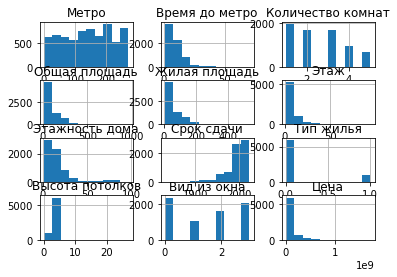

In [50]:
df.hist()

Видно, что у параметров Время до метро, Общая площадь, Жилая площадь, Этаж, Этажность дома унимодальное распределение,

с которым работать не желательно. Воспользуемся boxcox для нормализации данных

In [51]:
from scipy import stats
for x in ['Время до метро', 'Общая площадь', 'Жилая площадь', 'Этаж', 'Этажность дома']:
    df[x], _ = stats.boxcox(df[x])

Построим BoxPlot'ы для каждого параметра, который мы boxcoxили

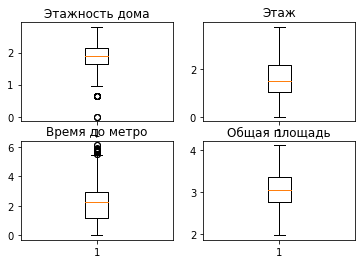

In [52]:
plt.subplot (2, 2, 1)
plt.boxplot(df['Этажность дома'])
plt.title('Этажность дома')

plt.subplot (2, 2, 2)
plt.boxplot(df['Этаж'])
plt.title('Этаж')

plt.subplot (2, 2, 3)
plt.boxplot(df['Время до метро'])
plt.title('Время до метро')

plt.subplot (2, 2, 4)
plt.boxplot(df['Общая площадь'])
plt.title('Общая площадь')
plt.show()

Преобразованные данные разобьем на обучающую и тестовую выборку, отнормируем данные на (0, 1) 

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X = df.drop('Цена', axis = 1)
y = df['Цена']
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

Обучим модель регрессии XGBoost и предскажем значения на тестовой выборке

In [54]:
from xgboost import XGBRegressor
regr = XGBRegressor(n_estimators = 10000, learning_rate = 0.15, random_state = 42)
regr.fit(X_train, y_train)
preds = regr.predict(X_test)

Построим график распределения весов фичей

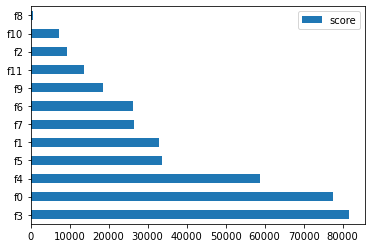

In [55]:
feature_important = regr.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

dat = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
dat.plot(kind='barh')
plt.show()

Посчитаем среднее отклонение предсказанного от настоящего значения цены

In [56]:
y_test = list(y_test)
errors = abs(preds[:700] - y_test[:700])
np.mean(errors/y_test[:700])

0.21602204734012534

Сохраним веса модели для дальнейшей работы в GUI

In [57]:
from joblib import dump
dump(regr, 'XGBoost.joblib')